In [1]:
import os
import pickle
import numpy as np
from mne import viz
from scipy import io, stats
from matplotlib import colors, pyplot as plt

In [2]:
CAF_DOSE = 400
SIGNIFICANT_P = 0.001

RESULTS_PATH = 'C:\\Users\\Philipp\\Documents\\Caffeine\\results\\randomForestAll{dose}'.format(dose=CAF_DOSE)
PROJECT_PATH = '..\\data' # path to where the EEG sensor position file is stored
FIGURE_PATH = 'C:\\Users\\Philipp\\GoogleDrive\\Caffeine\\results\\randomForest{dose}'.format(dose=CAF_DOSE)

STAGES = ['AWA', 'AWSL', 'REM']

In [3]:
# load EEG sensor positions to be used in the topomaps
sensor_pos = io.loadmat(os.path.join(PROJECT_PATH, 'Coo_caf'))['Cor'].T
sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T

In [4]:
# load the random forest results
with open(os.path.join(RESULTS_PATH, 'combined_results.pickle'), 'rb') as file:
    accuracies, importances, feature_names = pickle.load(file)

# generate cleaned feature names for plotting
feature_names_clean = {}
for stage in STAGES:
    feature_names_clean[stage] = np.array([name.replace('_', ' ').replace('SpecShanEn', 'Spectral entropy').replace('SampEn', 'Sample entropy') for name in feature_names[stage]])

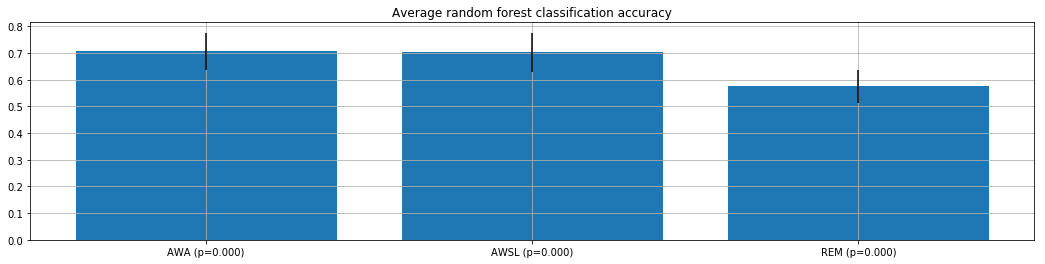

In [5]:
# calculate mean and standard deviation of accuracy values
acc = np.array([(accuracies[stage].mean(), accuracies[stage].std()) for stage in STAGES])
# compute 1 sample t-test for the accuracy values with null hypothesis acc=0.5 (random guess)
p = stats.ttest_1samp(np.array([accuracies[stage] for stage in STAGES]), 0.5, axis=1)[1]

# bar plot showing mean accuracy and standard deviation per sleep stage
plt.figure(figsize=(18, 4))
plt.title('Average random forest classification accuracy')
plt.bar(np.arange(len(acc)), acc[:,0], yerr=acc[:,1])
plt.xticks(np.arange(len(acc)), [f'{stage} (p={curr_p:.3f})' for stage, curr_p in zip(STAGES, p)])
plt.grid()
plt.savefig(os.path.join(FIGURE_PATH, 'stage_accuracies'))
plt.show()

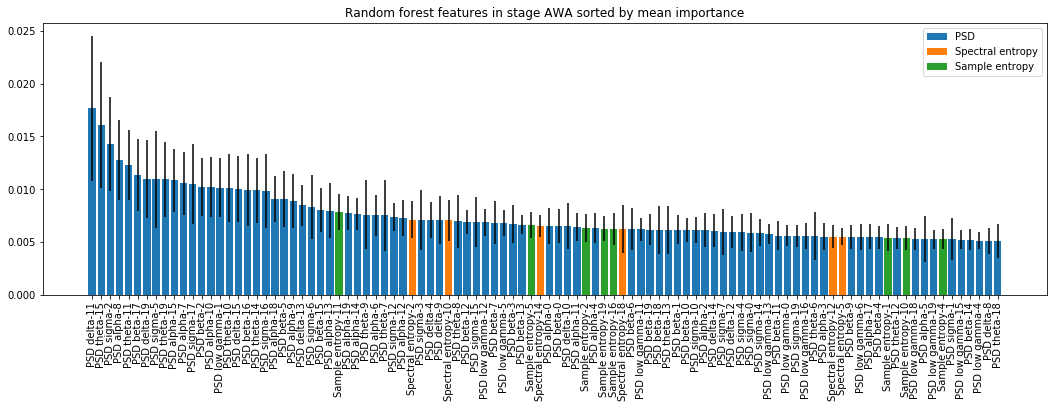

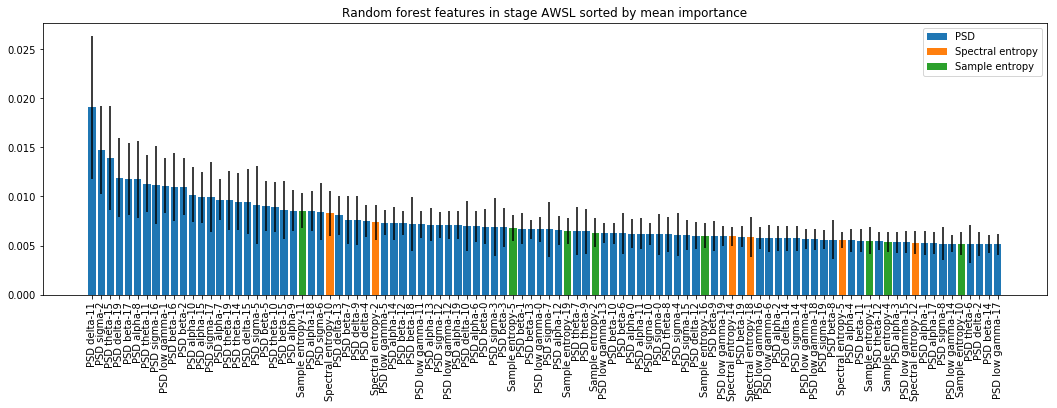

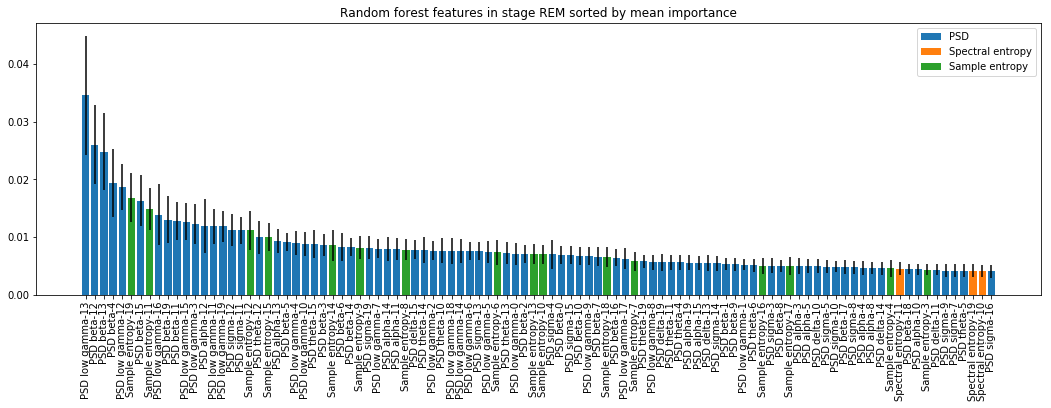

In [6]:
for stage in STAGES:
    # get feature importance mean and standard deviation
    means, stds = importances[stage].mean(axis=0), importances[stage].std(axis=0)
    # get a list of indices sorting the importances by value
    indices = np.argsort(means)[::-1][:100]
    
    # get boolean masks for each type of feature
    psd_mask = ['PSD' in feature for feature in feature_names[stage][indices]]
    spec_mask = ['SpecShanEn' in feature for feature in feature_names[stage][indices]]
    samp_mask = ['SampEn' in feature for feature in feature_names[stage][indices]]
    
    # plot feature importance means and standard deviations with different colors for different kinds of features 
    plt.figure(figsize=(18, 5))
    plt.title(f'Random forest features in stage {stage} sorted by mean importance')
    
    if np.sum(psd_mask) > 0:
        plt.bar(np.arange(len(indices))[psd_mask], means[indices][psd_mask], yerr=stds[indices][psd_mask], label='PSD')
    if np.sum(spec_mask) > 0:
        plt.bar(np.arange(len(indices))[spec_mask], means[indices][spec_mask], yerr=stds[indices][spec_mask], label='Spectral entropy')
    if np.sum(samp_mask) > 0:
        plt.bar(np.arange(len(indices))[samp_mask], means[indices][samp_mask], yerr=stds[indices][samp_mask], label='Sample entropy')
    
    plt.xticks(np.arange(len(indices)), feature_names_clean[stage][indices], rotation=90)
    plt.legend()
    plt.savefig(os.path.join(FIGURE_PATH, f'feature_importance-{stage}'))
    plt.show()

In [7]:
means, stds = [], []
for stage in STAGES:
    # get boolean masks for the different feature types
    psd_mask = ['PSD' in feature for feature in feature_names[stage]]
    spec_mask = ['SpecShanEn' in feature for feature in feature_names[stage]]
    samp_mask = ['SampEn' in feature for feature in feature_names[stage]]
    
    # get individual means for the different feature types
    means.append([
        importances[stage][:,psd_mask].mean(),
        importances[stage][:,spec_mask].mean(),
        importances[stage][:,samp_mask].mean()
    ])
    
    # get individual standard deviations for the different feature types
    stds.append([
        importances[stage][:,psd_mask].std(axis=0).mean(),
        importances[stage][:,spec_mask].std(axis=0).mean(),
        importances[stage][:,samp_mask].std(axis=0).mean()
    ])
    
means = np.array(means)
stds = np.array(stds)

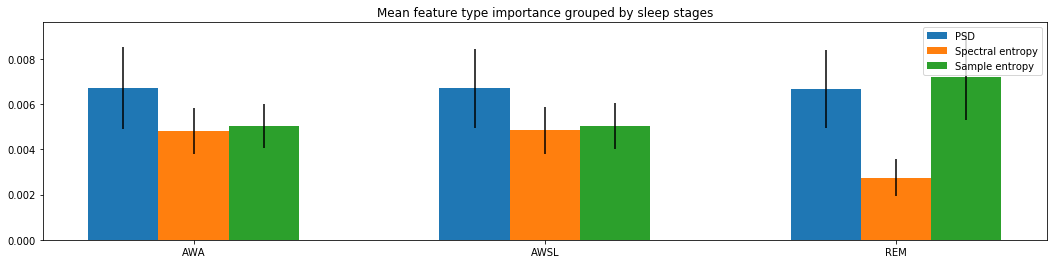

In [8]:
# bar width
width = 0.2

# plot mean feature importance per feature type grouped by sleep stage
plt.figure(figsize=(18, 4))
plt.title('Mean feature type importance grouped by sleep stages')

plt.bar(np.arange(len(means)), means[:,0], yerr=stds[:,0], width=width, label='PSD')
plt.bar(np.arange(len(means)) + width, means[:,1], yerr=stds[:,1], width=width, label='Spectral entropy')
plt.bar(np.arange(len(means)) + width * 2, means[:,2], yerr=stds[:,2], width=width, label='Sample entropy')

plt.xticks(np.arange(len(means)) + width, STAGES)
plt.legend()
plt.savefig(os.path.join(FIGURE_PATH, 'grouped_importance_1'))
plt.show()

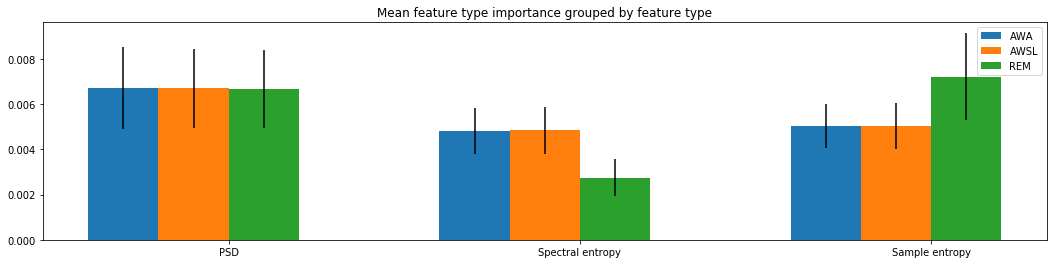

In [9]:
# bar width
width = 0.2

# plot mean feature importance per sleep stage grouped by feature type
plt.figure(figsize=(18, 4))
plt.title('Mean feature type importance grouped by feature type')

for i, stage in enumerate(STAGES):
    plt.bar(np.arange(means.shape[1]) + width * i, means[i], yerr=stds[i], width=width, label=stage)

plt.xticks(np.arange(means.shape[1]) + width * 1.5, ['PSD', 'Spectral entropy', 'Sample entropy'])
plt.legend()
plt.savefig(os.path.join(FIGURE_PATH, 'grouped_importance_2'))
plt.show()

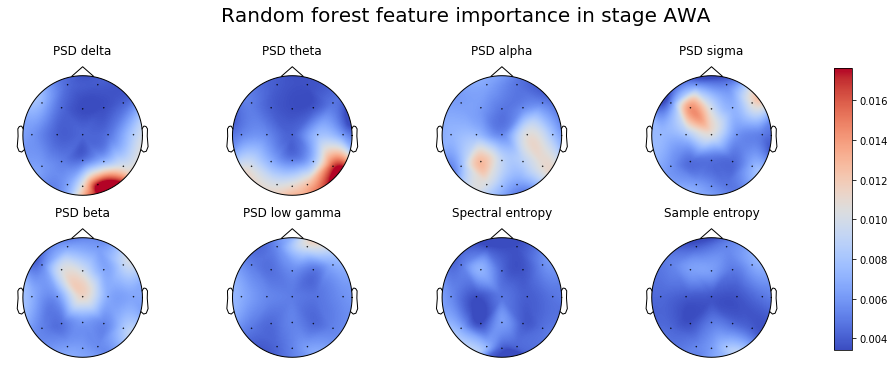

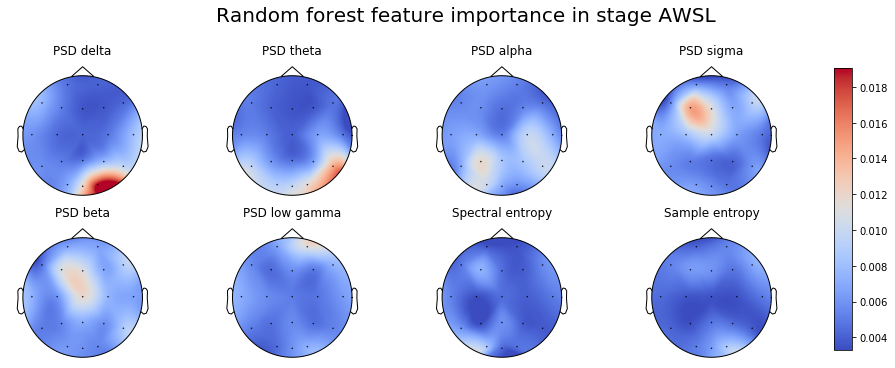

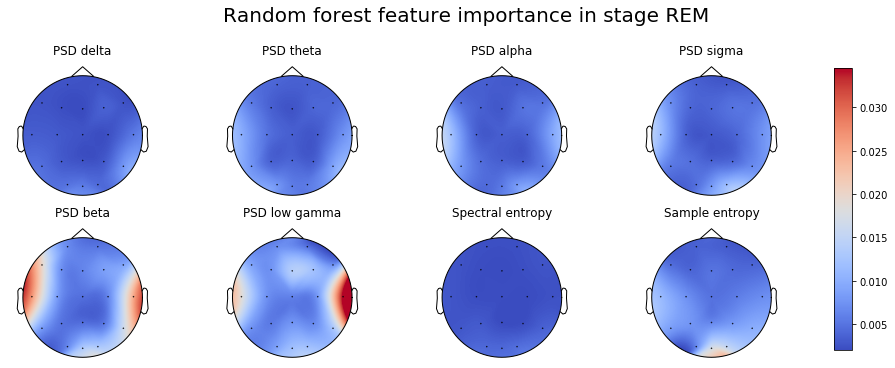

In [10]:
colormap = 'coolwarm'

for stage in STAGES:
    # get the mean feature importance and reshape to the form (features x electrodes)
    mean = importances[stage].mean(axis=0)
    mean = mean.reshape((-1, 20))

    vmin, vmax = np.min(mean), np.max(mean)
    
    # get the cleaned names features
    features = [name.split('-')[0] for name in feature_names_clean[stage][::20]]
    
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Random forest feature importance in stage {stage}', fontsize=20, y=1.1)
    
    axes = []
    for i in range(mean.shape[0]):
        # plot the current feature importance map in a new subplot
        axes.append(plt.subplot(2, 4, i + 1))
        plt.title(features[i])
        viz.plot_topomap(mean[i], sensor_pos, cmap=colormap, vmin=vmin, vmax=vmax, contours=False, show=False)
    
    # add a colorbar to the figure
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=axes, shrink=0.95, aspect=15)
    plt.savefig(os.path.join(FIGURE_PATH, f'feature_importance_maps-{stage}'))
    plt.show()